In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [3]:


# input image dimensions
img_rows, img_cols = 32, 32
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


In [5]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 500
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size = batch_size)



Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


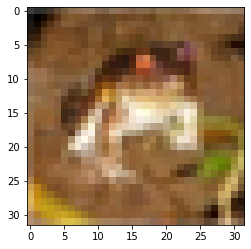

In [9]:
model = keras.models.load_model('vgg_based_100')

In [10]:
model.compile()

In [11]:
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv6__encoder (Conv6_Encod  multiple                 1250996   
 er)                                                             
                                                                 
 conv6__decoder (Conv6_Decod  multiple                 6071623   
 er)                                                             
                                                                 
 dense_4 (Dense)             multiple                  10100     
                                                                 
 dense_5 (Dense)             multiple                  10100     
                                                                 
Total params: 7,342,819
Trainable params: 7,328,595
Non-trainable params: 14,224
_________________________________________________________________


In [12]:
x_data = X_test[:2000]
y_data = y_test[:2000]

In [21]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard 
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)

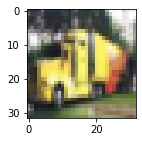

In [35]:
%matplotlib inline
j = 252
lat = model.encoder(x_data[j].reshape(1,32,32,3))
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(2)
plt.imshow(x_data[j])

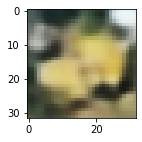

In [36]:
mu = model.mu(lat)
var = model.log_var(lat)
z = Sampling()(mu, var)
x_hat = tf.keras.activations.sigmoid(model.decoder(z))
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(2)
plt.imshow(x_hat[0])